<center><h2>K-omo solucionar Bogotá</h2></center>
<center><h2>Un acercamiento aplicado a K-Means y Clusters en Machine Learning</h2></center>
<center><h3>Juan David Dueñas Garavito</h3></center>


<h3>Ruta de trabajo</h3>
<p>La idea principal de este Notebook es generar toda la información necesaria para el IEEE UN Workshop a realizarse el 17 de abril, por lo cual vamos a enumerar diferentes tareas a realizar las cuales iran aumentando a medida que el proyecto se desarrolle, adicional el proyecto debe quedar estructurado de tal manera que podamos entregarlo como trabajo final de la materia Machine Learning para economistas. </p>

     - Empezamos detallando que es el algoritmo de k-means, k-nearest neigthbor y como funciona, ejemplos entre otros
     - Hablamos de las aplicaciones a urbanismo y datos espaciales
     - Introducimos el problema
     - Mostramos el algoritmo aplicado a lugares de trabajo vs lugares residenciales
     - Trabajamos con validaciones de TM buscando niveles de horas pico (volvemos a aplicar ML)
     - Concluimos con posibles soluciones 

<h2>¿Que es k-means y k-nearest neigthbor?</h2>  

<h3>K-means</h3>

Podemos decir que K-means es un metodo de clustering no supervisado en donde buscamos identificar y agrupar datos según k similitudes, el algoritmo que veremos más adelante busca asignar cada dato a alguno de los k grupos minimizando la varianza dentro de los grupos y maximizando la varianza entre los grupos. es decir, el objeto del algoritmo es formar conjuntos cuyos integrantes sean muy parecidos y que los conjuntos entre si sean muy diferentes.

Este algoritmo funciona de la siguente manera: sus inputs son unos datos y un número K, primero se generan k centroides y se le da a cada uno una posición geografica aleatoria, posterior empezamos la iteración de los siguientes dos pasos:

     - Asignamos cada dato a su centroide más cercano en función de la distancia cuadrada euclidiana, 
       matematicamente se puede ver de la siguiente manera:
       
<center> 
    $\underset{c_i}{\text{min}}\, dist(c_{i}, x)^2$
</center>

    - actualizamos la posición de los centroides, la nueva posición del centroide j será determinada a partir de la media de
      todos los puntos del grupo j, matematicamente se puede ver de la siguiente manera:
    
<center>
    $c_j = \frac{1}{|S_j|}\sum_{x_i \in S_j} x_i$
</center>

Esta iteración va a terminar convergiendo a un punto en el cual la posición de los centroides despues de cada iteración no va a cambiar significativamente.


<h3>Ejemplo</h3>

Inciamos importando las librerias para llevar a cabo este algoritmo, a su vez que creamos un dataframe de ejemplo 

In [13]:
from sklearn.datasets import load_iris
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

mall_customers = load_iris(as_frame=True)
X = mall_customers.data.values

Visualizamos el Dataframe

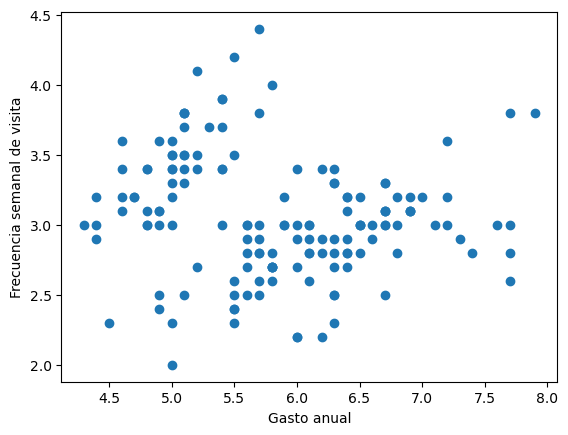

In [14]:
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('Gasto anual')
plt.ylabel('Frecuencia semanal de visita')
plt.show()

Estandarizamos (media = 0 y varianza unitaria) los datos para posteriormente aplicar el kmeans con k=2 es decir dos conjuntos de datos, lo visualizamos con Matplotlib y le pedimos que nos permita ver la posición de los 2 centroides generados

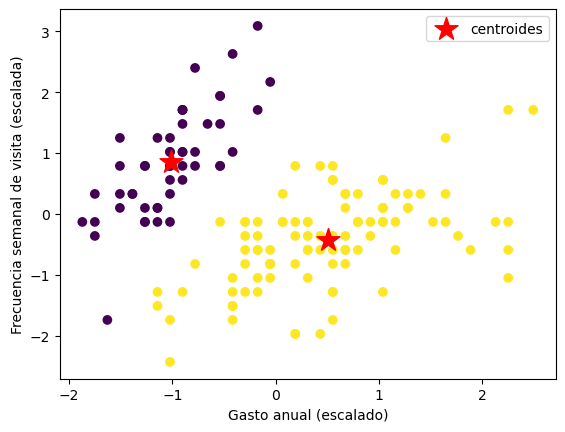

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_scaled)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans.labels_)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
            color='r', label='centroides')
plt.legend()
plt.xlabel('Gasto anual (escalado)')
plt.ylabel('Frecuencia semanal de visita (escalada)')
plt.show()

<h3>K-nearest neighbor</h3>

Este es un algoritmo de aprendizaje supervizado basado en instancias (modelo a partir de una base de datos para luego agregar más bases de datos) en donde buscamos clasificar nuevos datos o hacer predicción. al clasificar nuevos datos buscamos que estos sean los más cercanos a los establecidos en la etapa de aprendizaje, en K-nearest neighbor la k signinfica la cantidad de puntos vecinos que tenemos en cuenta para clasificar los n-grupos.

K-nearest neighbor funciona de la siguiente manera:

    - Seleccionamos un valor de K
    - Calculamos la distancia entre el nuevo dato y el resto de items del dataset de entrenamiento
    - Seleccionamos los K-elementos más cercanos
    - Asignamos al item la clase que sea mayoria entre los k vecinos

Para calcular la distancia podemos usar distancias euclidianas u otras alternativas como manthattan, el resultado del modelo nos dirá que tan eficiente es este modelo al asignar clases o etiquetas a cada uno de los datos en comparación con el Dataframe de prueba

<h3>Ejemplo</h3>

Iniciamos importando las librerias que nos son de ayuda para llevar a cabo este modelo

In [16]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

Importamos el dataframe y los dividimos entre entrenamiento y prueba

In [17]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=42)

Aplicamos el KNN sobre el conjunto de entrenamiento con un K de 5

In [18]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsRegressor()

Con el modelo hacemos una regresión y calculamos el error cuadrado o en otras palabras, el error entre el lo que estima el modelo bajo los datos de prueba y los nuevos datos

In [19]:
y_pred = knn.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.011555555555555552


<h2>Aplicaciones a urbanismo y datos espaciales</h2>

Nos podemos dar cuenta que tanto K-means como KNN hablan de unas ubicaciones geograficas teoricas para su proceso de clustering. es por este detalle que nos podemos permitir trabajar datos espaciales cambiando las ubicaciones geograficas teorias por reales y de este modo logrando aplicaciones a campos que deben usar referencias espaciales, en este caso la aplicaremos al urbanismo.

Cuando hablamos de correlaciones espaciales empezamos a introducirnos en el campo de la Econometría Espacial. 

<h2>El problema de Bogotá </h2>

Trancones, trancones y más trancones queremos sacar el comportamiento de Transmilenio durante un dia promedio... (completar)

In [126]:
import requests
import numpy as np
import pandas as pd
import geopandas as gpd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from shapely.geometry import Point
import contextily as ctx
import plotly.express as px
import imageio
import kaleido
from io import BytesIO
pd.options.mode.chained_assignment = None

Descargamos un dataset desde los datos abiertos de transmilenio, especificamente las validaciones del componente troncal

In [127]:
if not os.path.isfile("../datos/tm/validacionTroncal20230213.csv"):
    url = 'https://storage.googleapis.com/validaciones_tmsa/ValidacionTroncal/validacionTroncal20230213.csv'
    response = requests.get(url)

    with open('../datos/tm/validacionTroncal20230213.csv', 'wb') as file:
        file.write(response.content)
else:
    print("ARCHIVO YA EXISTE")

ARCHIVO YA EXISTE


Abrimos el Dataset en Pyton para hacer un adecuado proceso de EDA, identificamos variables, fomatos, posibles datos nulos y seleccionamos las variables que son de nuestro interes (Estacion_Parada y Fecha_transacción en este caso).

In [128]:
data = pd.read_csv("../datos/tm/validacionTroncal20230213.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1933333 entries, 0 to 1933332
Data columns (total 22 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Acceso_Estacion             object 
 1   Day_Group_Type              object 
 2   Dispositivo                 int64  
 3   Emisor                      object 
 4   Estacion_Parada             object 
 5   Fase                        object 
 6   Fecha_Clearing              object 
 7   Fecha_Transaccion           object 
 8   Hora_Pico_SN                object 
 9   ID_Vehiculo                 float64
 10  Linea                       object 
 11  Nombre_Perfil               object 
 12  Numero_Tarjeta              object 
 13  Operador                    object 
 14  Ruta                        float64
 15  Saldo_Despues_Transaccion   float64
 16  Saldo_Previo_a_Transaccion  float64
 17  Sistema                     object 
 18  Tipo_Tarifa                 int64  
 19  Tipo_Tarjeta         

In [129]:
data.isnull().sum()

Acceso_Estacion                     0
Day_Group_Type                      0
Dispositivo                         0
Emisor                              0
Estacion_Parada                     0
Fase                                0
Fecha_Clearing                      0
Fecha_Transaccion                   0
Hora_Pico_SN                        0
ID_Vehiculo                   1933333
Linea                               0
Nombre_Perfil                       0
Numero_Tarjeta                      0
Operador                            0
Ruta                          1933333
Saldo_Despues_Transaccion           0
Saldo_Previo_a_Transaccion          0
Sistema                             0
Tipo_Tarifa                         0
Tipo_Tarjeta                        0
Tipo_Vehiculo                 1933333
Valor                               0
dtype: int64

In [130]:
data.head()

,Acceso_Estacion,Day_Group_Type,Dispositivo,Emisor,Estacion_Parada,Fase,Fecha_Clearing,Fecha_Transaccion,Hora_Pico_SN,ID_Vehiculo,...,Numero_Tarjeta,Operador,Ruta,Saldo_Despues_Transaccion,Saldo_Previo_a_Transaccion,Sistema,Tipo_Tarifa,Tipo_Tarjeta,Tipo_Vehiculo,Valor
0,(01) Acceso Peatonal Oriental,Dia 1,650000187,(3101000) Bogota Card(Citizen),(06101) El Tiempo,Fase 3,2023-02-13,2023-02-09 17:10:04,Peak Time,NaN,...,1418b2335cf1f3046a6f6cdc6753738e8cbfbbcb859c9e...,(201) Trunk agency,NaN,2700.0,5650.0,TRONCAL,1,tullave Básica,NaN,2950.0
1,(01) Acceso Peatonal Oriental,Dia 1,650000187,(3101000) Bogota Card(Citizen),(06101) El Tiempo,Fase 3,2023-02-13,2023-02-09 17:10:07,Peak Time,NaN,...,9bb6a348bb551dce8ed2722cba5952d2a3a4ad64fd6d53...,(201) Trunk agency,NaN,72200.0,75150.0,TRONCAL,1,tullave Básica,NaN,2950.0
2,(01) Acceso Peatonal Oriental,Dia 1,650000187,(3101000) Bogota Card(Citizen),(06101) El Tiempo,Fase 3,2023-02-13,2023-02-09 17:10:09,Peak Time,NaN,...,ae8bba7198445b384a9dc4d3e3070e6b1cac305175080c...,(201) Trunk agency,NaN,40500.0,43450.0,TRONCAL,1,tullave Plus,NaN,2950.0
3,(01) Acceso Peatonal Oriental,Dia 1,650000187,(3101000) Bogota Card(Citizen),(06101) El Tiempo,Fase 3,2023-02-13,2023-02-09 17:10:12,Peak Time,NaN,...,f60eb33d0d9a384baf461d904e9fdb4d06c1968c47a367...,(201) Trunk agency,NaN,8200.0,11150.0,TRONCAL,1,tullave Plus,NaN,2950.0
4,(01) Acceso Peatonal Oriental,Dia 1,650000187,(3101000) Bogota Card(Citizen),(06101) El Tiempo,Fase 3,2023-02-13,2023-02-09 17:10:15,Peak Time,NaN,...,91ed4f30f14a62df0b9c7e52b0b5d1f902d0e332c9da76...,(201) Trunk agency,NaN,24450.0,27400.0,TRONCAL,1,tullave Básica,NaN,2950.0


In [131]:
Estaciones = data[["Estacion_Parada","Fecha_Transaccion"]].copy()
Estaciones["numero_est"] = Estaciones["Estacion_Parada"].str[1:6]
Estaciones["nombre_est"] = Estaciones["Estacion_Parada"].str[8:]
Estaciones.head()

,Estacion_Parada,Fecha_Transaccion,numero_est,nombre_est
0,(06101) El Tiempo,2023-02-09 17:10:04,06101,El Tiempo
1,(06101) El Tiempo,2023-02-09 17:10:07,06101,El Tiempo
2,(06101) El Tiempo,2023-02-09 17:10:09,06101,El Tiempo
3,(06101) El Tiempo,2023-02-09 17:10:12,06101,El Tiempo
4,(06101) El Tiempo,2023-02-09 17:10:15,06101,El Tiempo


In [132]:
Estaciones.head()

,Estacion_Parada,Fecha_Transaccion,numero_est,nombre_est
0,(06101) El Tiempo,2023-02-09 17:10:04,06101,El Tiempo
1,(06101) El Tiempo,2023-02-09 17:10:07,06101,El Tiempo
2,(06101) El Tiempo,2023-02-09 17:10:09,06101,El Tiempo
3,(06101) El Tiempo,2023-02-09 17:10:12,06101,El Tiempo
4,(06101) El Tiempo,2023-02-09 17:10:15,06101,El Tiempo


Dividimos la fecha entre fecha (dia, mes y año) y hora para luego volverlos un dato de tiempo, más facil de manejar

In [133]:
Estaciones["Fecha_Transaccion"] = pd.to_datetime(Estaciones["Fecha_Transaccion"])
#data["hora"] = pd.to_datetime(data["hora"], format="%m/%d/%Y, %H:%M:%S")

Ahora analizamos los datos de las fechas para entender la extensión de nuestro DataSet

In [134]:
Estaciones.head()

,Estacion_Parada,Fecha_Transaccion,numero_est,nombre_est
0,(06101) El Tiempo,2023-02-09 17:10:04,06101,El Tiempo
1,(06101) El Tiempo,2023-02-09 17:10:07,06101,El Tiempo
2,(06101) El Tiempo,2023-02-09 17:10:09,06101,El Tiempo
3,(06101) El Tiempo,2023-02-09 17:10:12,06101,El Tiempo
4,(06101) El Tiempo,2023-02-09 17:10:15,06101,El Tiempo


In [135]:
Estaciones['Fecha_Transaccion'].dt.day.value_counts()

13    1933101
9         134
14         98
Name: Fecha_Transaccion, dtype: int64

Nos damos cuenta que el grueso de los datos se encuentra el 13 de febrero. Por ende, limitamos nuestra base de datos a las validaciones ocurridas durante esta fecha y graficamos la frecuencia por tiempo de las validaciones en el sistema troncal, ademas de eliminar datos atipicos generados en horas fuera del funcionamiento de Transmilenio

In [136]:
Estaciones13Feb = Estaciones.loc[Estaciones["Fecha_Transaccion"].dt.day == 13]
Estaciones13Feb = Estaciones13Feb.loc[Estaciones["Fecha_Transaccion"].dt.hour >= 5]
Estaciones13Feb = Estaciones13Feb.loc[Estaciones["Fecha_Transaccion"].dt.hour <= 22]

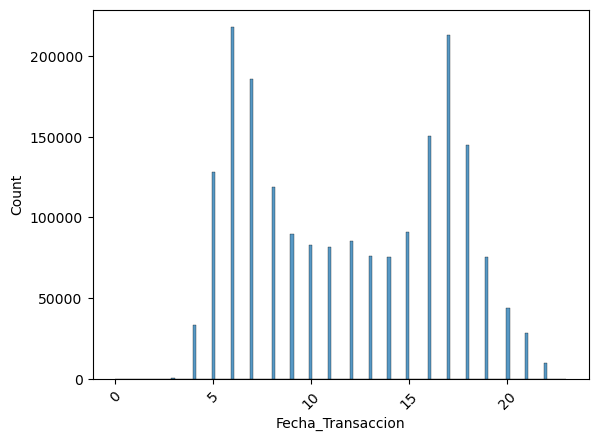

In [137]:
sns.histplot(data=Estaciones13Feb, x=Estaciones["Fecha_Transaccion"].dt.hour)
plt.xticks(rotation=45)
plt.show()

Cada una de las estaciones va a tener una distribución diferente de validaciones a lo largo del dia, la hipotesis radica en que las estaciones se dividen en 2 tipos, las estaciones residenciales y las estaciones laborales. En las primeras vamos a encontrar más validaciones en la hora pico de la mañana mientras que en las segundas vamos a encontrar más validaciones de lo normal en la hora pico de la tarde. Para esto vamos a graficar dos estaciones de ejemplo

Empezamos con lo que considerariamos una estación laboral, calle 100

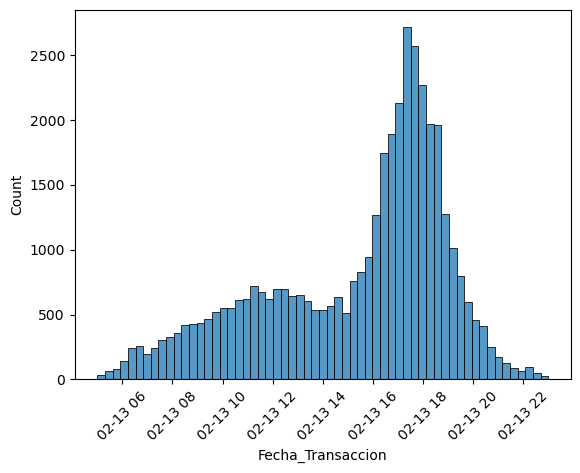

In [138]:
Estaciones13Feb.groupby(by='nombre_est') 
estacion_calle100 = Estaciones13Feb.groupby('nombre_est').get_group("Calle 100")

sns.histplot(data=estacion_calle100, x=estacion_calle100["Fecha_Transaccion"])
plt.xticks(rotation=45)
plt.show()

Como nos podemos dar cuenta la mayoria de validaciones de esta estación se encuentra en horas de la tarde, por otro lado una estación residencial como patio bonito tiene la siguiente distribución:

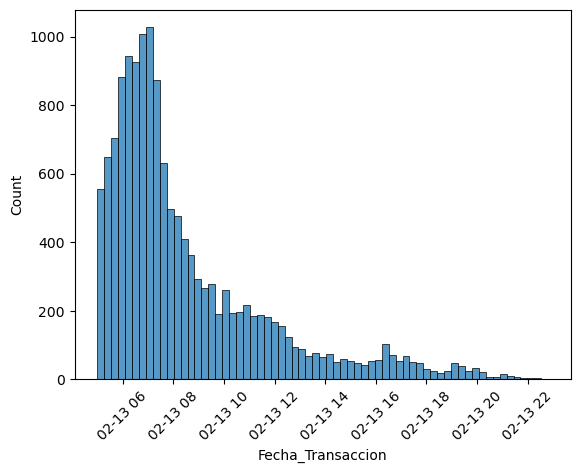

In [139]:
estacion_patio_bonito = Estaciones13Feb.groupby('nombre_est').get_group("Patio Bonito")

sns.histplot(data=estacion_patio_bonito, x=estacion_patio_bonito["Fecha_Transaccion"])
plt.xticks(rotation=45)
plt.show()

Agregando las 155 distribuciones (una por cada estación) nos encontramos con la siguiente grafica:

C:\Users\PC\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



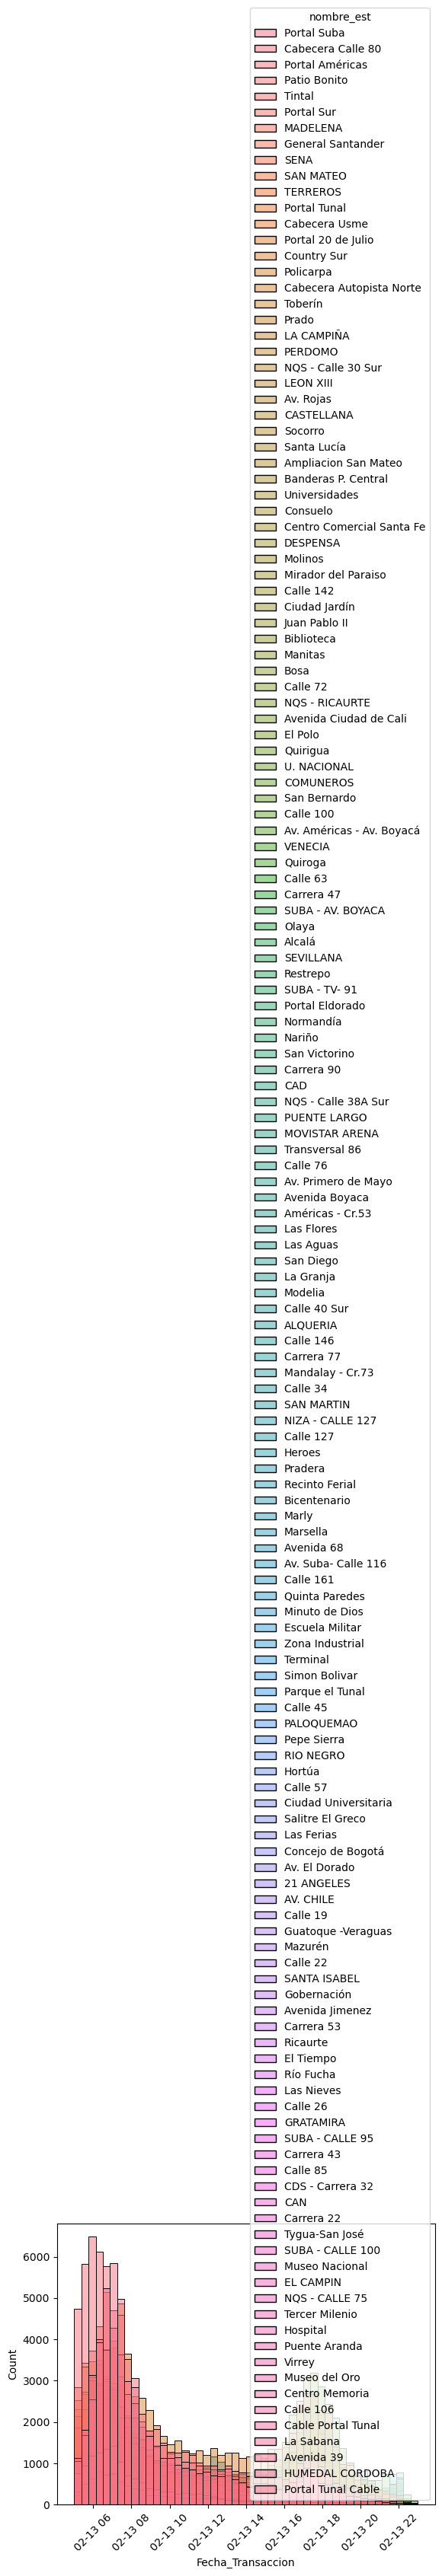

In [140]:
sns.histplot(data=Estaciones13Feb, x="Fecha_Transaccion", hue='nombre_est', bins=48)
plt.xticks(rotation=45)
plt.show()

Es decir cada estación tiene su propia distribución durante el transcurso del día, para visualizar esto de mejor manera podemos ayudarnos de heatmaps que hagan cortes transversales a las distribuciones durante el dia.

Para esto empezamos a integrar los datos espaciales, importamos el Shapefile previamente descargado en nuestro local y visualizamos cada una de la ubicaciones espaciales de las estaciones de Trasmilenio sobre el mapa de Bogotá

In [141]:
troncales_shapefile = gpd.read_file("../datos/tm/Estaciones_Troncales_de_TRANSMILENIO.shp")
troncales_shapefile["longitud_y_latitud"] = troncales_shapefile["geometry"]
troncales_shapefile["longitud_y_latitud"] = troncales_shapefile["longitud_y_latitud"].astype(str)
troncales_shapefile["longitud_y_latitud"] = troncales_shapefile["longitud_y_latitud"].str[7:-1]


troncales_shapefile[['longitud', 'latitud']] = troncales_shapefile['longitud_y_latitud'].str.split(' ', 1, expand=True)
troncales_shapefile.head()

,objectid,numero_est,nombre_est,coordenada,coordena_1,ubicacion_,troncal_es,numero_vag,numero_acc,biciestaci,...,last_edite,last_edi_1,codigo_nod,componente,componen_1,log_replic,geometry,longitud_y_latitud,longitud,latitud
0,1,07103,AV. Chile,1.000327e+06,1.007756e+06,Kr 30 Cl 72,NQS,6,2,0,...,NaN,NaN,7103,NaN,NaN,NaN,POINT (-74.07456 4.66634),-74.0746 4.66634,-74.0746,4.66634
1,2,06103,CAN,9.976100e+05,1.005604e+06,Carrera 60,Calle 26,4,1,0,...,NaN,NaN,6103,NaN,NaN,NaN,POINT (-74.09905 4.64688),-74.099 4.64688,-74.099,4.64688
2,3,07106,Campín,9.998678e+05,1.005440e+06,Kr 30 Cl 53,NQS,2,2,0,...,NaN,NaN,7106,NaN,NaN,NaN,POINT (-74.07870 4.64540),-74.0787 4.6454,-74.0787,4.6454
3,4,10008,San Diego,1.000667e+06,1.001625e+06,Kra 10- Cl23,Cr 7-10,2,2,0,...,NaN,NaN,10008,NaN,NaN,NaN,POINT (-74.07150 4.61090),-74.0715 4.6109,-74.0715,4.6109
4,5,04100,Granja - Carrera 77,9.979466e+05,1.011384e+06,Carrera 77 Bis,Calle 80,3,2,0,...,NaN,NaN,4100,NaN,NaN,NaN,POINT (-74.09602 4.69915),-74.096 4.69915,-74.096,4.69915


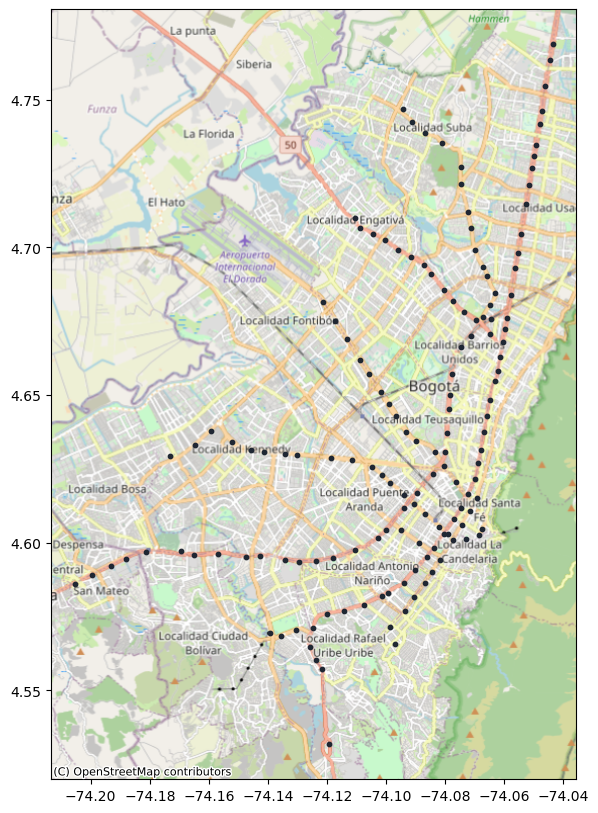

In [142]:
fig, ax = plt.subplots(figsize=(10, 10))
troncales_shapefile.plot(ax=ax, color="#1f2733", markersize=10, alpha=1)
ctx.add_basemap(ax, crs=troncales_shapefile.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

In [143]:
EstacionesHH = Estaciones13Feb.groupby(["nombre_est" ,pd.Grouper(key='Fecha_Transaccion', freq='30min')]).count()
EstacionesHH = EstacionesHH.reset_index()

corte_5_am = EstacionesHH["Fecha_Transaccion"] == "2023-02-13 05:00:00"
EstacionesHH[corte_5_am]

,nombre_est,Fecha_Transaccion,Estacion_Parada,numero_est
0,21 ANGELES,2023-02-13 05:00:00,68,68
36,ALQUERIA,2023-02-13 05:00:00,178,178
72,AV. CHILE,2023-02-13 05:00:00,69,69
108,Alcalá,2023-02-13 05:00:00,157,157
144,Ampliacion San Mateo,2023-02-13 05:00:00,1454,1454
...,...,...,...,...
5353,U. NACIONAL,2023-02-13 05:00:00,48,48
5389,Universidades,2023-02-13 05:00:00,165,165
5425,VENECIA,2023-02-13 05:00:00,234,234
5461,Virrey,2023-02-13 05:00:00,10,10


In [144]:
lista_cortes = []

for i in range(5, 23):
    lista_cortes.append("2023-02-13"+" "+str(i)+":00:00")
    lista_cortes.append("2023-02-13"+" "+str(i)+":30:00")

nombre_cortes = lista_cortes.copy()
mapa_cortes = lista_cortes.copy()

for i in range(len(nombre_cortes)):
    nombre_cortes[i] = "corte"+" "+str(nombre_cortes[i])
    
for i in range(len(mapa_cortes)):
    mapa_cortes[i] = "mapa"+" "+str(mapa_cortes[i])

for i in range(len(nombre_cortes)):
    nombre_cortes[i] = EstacionesHH["Fecha_Transaccion"] == lista_cortes[i]
    nombre_cortes[i] = EstacionesHH[nombre_cortes[i]]
    nombre_cortes[i].rename(columns={"Estacion_Parada": "Validaciones"}, inplace=True)
    nombre_cortes[i] = pd.merge(troncales_shapefile, nombre_cortes[i], on="nombre_est")
    nombre_cortes[i].drop("numero_est_y", axis=1, inplace=True)
    mapa_cortes[i] = px.density_mapbox(nombre_cortes[i], 
                        lat='latitud', 
                        lon='longitud', 
                        z='Validaciones', 
                        radius=20, 
                        center=dict(lat=4.64688, lon=-74.099), 
                        zoom=10, 
                        mapbox_style='open-street-map')
    #fig = mapa_cortes[i]
    #ruta_archivo = "../datos/tm/heatmap"+str(i)+".png"
    #pio.write_image(fig, ruta_archivo, format='png', width=800, height=600)


    
    



In [145]:
mapa_cortes[2]

In [146]:
mapa_cortes[35]